<a href="https://colab.research.google.com/github/youneslam/DetectBat/blob/main/DetectBat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation of rooftops using U_net


In [ ]:
from google.colab import files

uploaded = files.upload()
uploaded_anno = files.upload()

Saving images.zip to images.zip


Saving project-1-at-2025-06-24-13-25-3a442505.zip to project-1-at-2025-06-24-13-25-3a442505.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("images.zip", 'r') as zip_ref:
    zip_ref.extractall("images")
with zipfile.ZipFile("project-1-at-2025-06-24-13-25-3a442505.zip", 'r') as zip_ref:
    zip_ref.extractall("annotations")

In [ ]:
import numpy as np
from PIL import Image
import os

image_folder = "images/images/"
annotation_folder = "annotations/"

task_id = 6

# Try to find the image file with or without leading zeros and with .jpg or .JPG extension
img_path = None
for ext in ['.jpg', '.JPG']:
    # Try with zero-padded task_id
    padded_img_filename = f"task_{task_id:05d}{ext}"
    padded_img_path = os.path.join(image_folder, padded_img_filename)
    if os.path.exists(padded_img_path):
        img_path = padded_img_path
        break

    # Try with non-padded task_id
    non_padded_img_filename = f"task{task_id}{ext}"
    non_padded_img_path = os.path.join(image_folder, non_padded_img_filename)
    if os.path.exists(non_padded_img_path):
        img_path = non_padded_img_path
        break

if img_path:
    image = Image.open(img_path)
    image_array = np.array(image)

    # Find the annotation file for the given task_id
    anno_file = None
    for root, dirs, files in os.walk(annotation_folder):
        for file in files:
            if file.startswith(f"task-{task_id}-") and file.endswith(".npy"):
                anno_file = file
                break
        if anno_file:
            break

    if anno_file:
        anno_path = os.path.join(annotation_folder, anno_file)
        annotation = np.load(anno_path)

        print("Image shape:", image_array.shape)
        print("Annotation shape:", annotation.shape)
    else:
        print(f"Annotation file not found for task_id {task_id}")
else:
    print(f"Image file not found for task_id {task_id} in {image_folder}")

Image shape: (3648, 5472, 3)
Annotation shape: (3648, 5472)


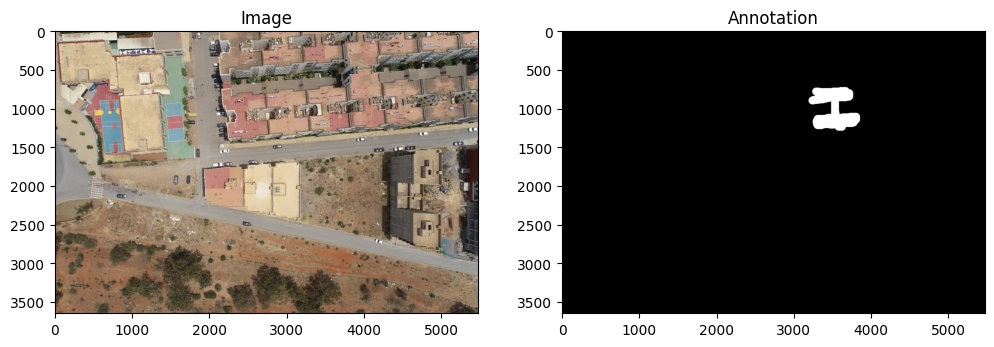

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(image_array)

plt.subplot(1,2,2)
plt.title("Annotation")
plt.imshow(annotation, cmap='gray')

plt.show()


In [ ]:
import numpy as np
from PIL import Image
import os

def load_image_and_annotation(task_id, image_folder, annotation_folder):
    img_path = None
    for ext in ['.jpg', '.JPG']:
        padded_img_filename = f"task_{task_id:05d}{ext}"
        padded_img_path = os.path.join(image_folder, padded_img_filename)
        if os.path.exists(padded_img_path):
            img_path = padded_img_path
            break

        non_padded_img_filename = f"task{task_id}{ext}"
        non_padded_img_path = os.path.join(image_folder, non_padded_img_filename)
        if os.path.exists(non_padded_img_path):
            img_path = non_padded_img_path
            break

    if not img_path:
        raise FileNotFoundError(f"Image file not found for task_id {task_id} in {image_folder}")

    image = Image.open(img_path)
    image_array = np.array(image)

    # Find all annotation files for the given task_id
    anno_files = []
    for root, dirs, files in os.walk(annotation_folder):
        for file in files:
            if file.startswith(f"task-{task_id}-") and file.endswith(".npy"):
                anno_files.append(os.path.join(root, file))

    if not anno_files:
        raise FileNotFoundError(f"Annotation file(s) not found for task_id {task_id} in {annotation_folder}")

    # Load and combine all annotations into a single mask (taking the union)
    # Assuming annotations are binary masks with values 0 or 1
    combined_mask = None
    for anno_path in anno_files:
        annotation = np.load(anno_path)
        if combined_mask is None:
            combined_mask = annotation
        else:
            # Combine masks (e.g., using logical OR for binary masks)
            combined_mask = np.maximum(combined_mask, annotation)

    return image_array, combined_mask

In [ ]:
from tensorflow.keras.utils import Sequence
from PIL import Image
import numpy as np
import os
import random

class DataGenerator(Sequence):
    def __init__(self, list_ids, image_folder, annotation_folder, batch_size=8, image_size=(128,128), shuffle=True, augment=True):
        self.list_ids = list_ids
        self.image_folder = image_folder
        self.annotation_folder = annotation_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment # Add augmentation flag
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_ids = self.list_ids[index*self.batch_size:(index+1)*self.batch_size]
        images, masks = self.__data_generation(batch_ids)
        return images, masks

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.list_ids)

    def __data_generation(self, batch_ids):
        images = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.image_size, 1), dtype=np.float32)

        for i, task_id in enumerate(batch_ids):
            img, mask = load_image_and_annotation(task_id, self.image_folder, self.annotation_folder)

            # Resize image
            img = Image.fromarray(img).resize(self.image_size)
            img = np.array(img)

            # Resize mask
            mask = Image.fromarray(mask).resize(self.image_size, Image.NEAREST) # Use NEAREST for masks to avoid interpolation issues
            mask = np.array(mask)
            mask = (mask > 0).astype(np.float32)  # Binarisation si besoin

            # Apply augmentation if enabled
            if self.augment:
                if random.random() > 0.5: # Horizontal flip
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)
                if random.random() > 0.5: # Vertical flip
                    img = np.flipud(img)
                    mask = np.flipud(mask)

            # Normalize image after augmentation
            img = img / 255.0
            mask = np.expand_dims(mask, axis=-1)


            images[i,] = img
            masks[i,] = mask

        return images, masks

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(128,128,3)):
    inputs = Input(input_size)

    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(32, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │     32,832 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │      8,224 │ conv2d_9[0][0]  

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Remove task_id 10 and 11 as their annotation files are missing
list_ids = [1,2,3,4,5,6,7,8,9,12,13,14,15]

train_gen = DataGenerator(list_ids, image_folder="images/images/", annotation_folder="annotations/", batch_size=4, image_size=(128,128))

model.fit(train_gen, epochs=20)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4449 - loss: 0.6962
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8466 - loss: 0.6641
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8563 - loss: 0.5981
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8447 - loss: 0.5073
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8505 - loss: 0.4775
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8549 - loss: 0.4727
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8153 - loss: 0.5314
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8497 - loss: 0.4724
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8344 - loss: 0.4952
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.8502 - loss: 0.4621
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8308 - loss: 0.4917
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8454 - loss: 0.4614
Epoch 13/20
3/3 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
Maximum value in raw prediction: 0.4945411
Using threshold: 0.001
Sample of predicted mask array:
[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


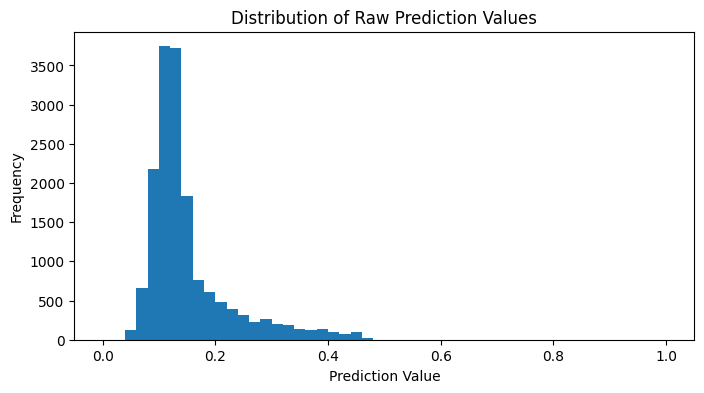

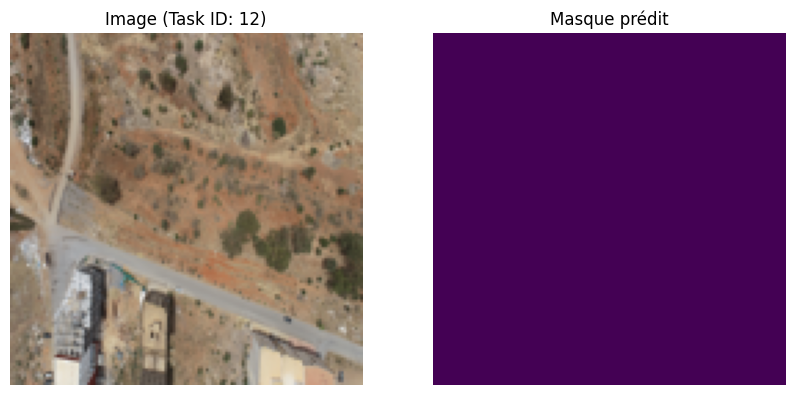

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

def predict_mask(task_id, image_folder, model, image_size=(128,128)):
    # Try to find the image file with or without leading zeros and with .jpg or .JPG extension
    img_path = None
    for ext in ['.jpg', '.JPG']:
        # Try with zero-padded task_id
        padded_img_filename = f"task_{task_id:05d}{ext}"
        padded_img_path = os.path.join(image_folder, padded_img_filename)
        if os.path.exists(padded_img_path):
            img_path = padded_img_path
            break

        # Try with non-padded task_id
        non_padded_img_filename = f"task{task_id}{ext}"
        non_padded_img_path = os.path.join(image_folder, non_padded_img_filename)
        if os.path.exists(non_padded_img_path):
            img_path = non_padded_img_path
            break

    if not img_path:
        raise FileNotFoundError(f"Image file not found for task_id {task_id} in {image_folder}")

    img = Image.open(img_path).resize(image_size)
    img_array = np.array(img) / 255.0
    input_tensor = np.expand_dims(img_array, axis=0)

    raw_pred_mask = model.predict(input_tensor)[0,...,0]
    print("Maximum value in raw prediction:", np.max(raw_pred_mask))
    # Lower the threshold
    threshold = 0.001 # Explicitly state the threshold
    print(f"Using threshold: {threshold}")
    pred_mask = (raw_pred_mask > threshold).astype(np.uint8)

    # Print a small section of the predicted mask array
    print("Sample of predicted mask array:")
    print(pred_mask[50:60, 50:60])

    # Plot histogram of raw prediction values
    plt.figure(figsize=(8, 4))
    plt.hist(raw_pred_mask.ravel(), bins=50, range=(0, 1))
    plt.title("Distribution of Raw Prediction Values")
    plt.xlabel("Prediction Value")
    plt.ylabel("Frequency")
    plt.show()


    return img_array, pred_mask

# Test with a task_id, for example 12
test_task_id = 12
image_folder_path = "images/images/"
img, pred_mask = predict_mask(test_task_id, image_folder_path, model)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title(f"Image (Task ID: {test_task_id})")
plt.imshow(img)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Masque prédit")

plt.imshow(pred_mask, cmap='viridis')
plt.axis('off')

plt.show()
#Thr data is too small to fetch our model

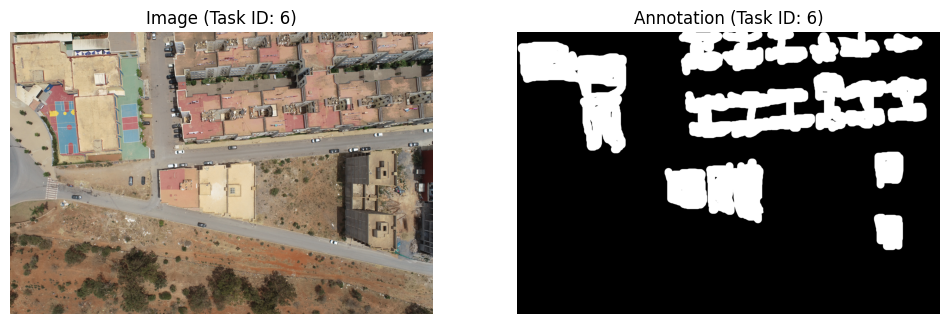

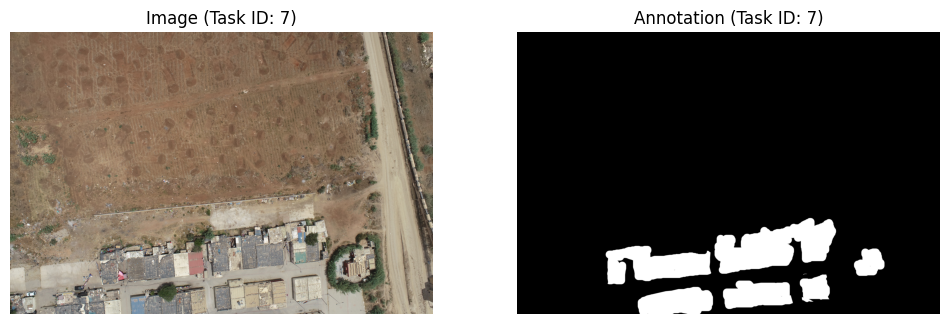

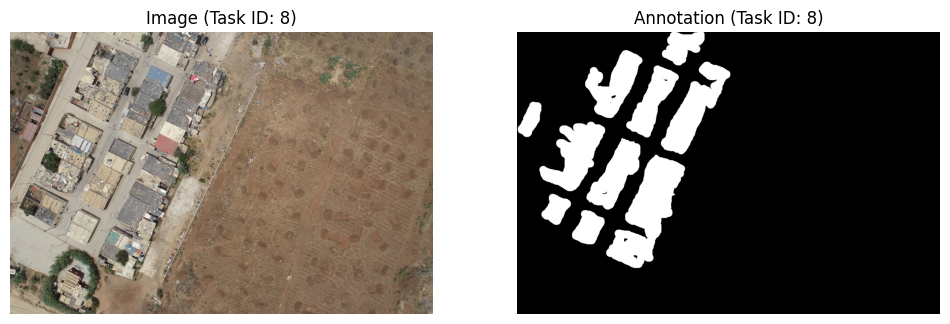

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Assuming list_ids contains the task IDs used for training
# We can visualize a few examples from the training set
list_ids = [6,7,8,9,12,13,14,15]
image_folder = "images/images/"
annotation_folder = "annotations/"

# Visualize the first 3 images and annotations from the training set
for i in range(min(3, len(list_ids))):
    task_id = list_ids[i]
    try:
        img, annotation = load_image_and_annotation(task_id, image_folder, annotation_folder)

        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.title(f"Image (Task ID: {task_id})")
        plt.imshow(img)
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title(f"Annotation (Task ID: {task_id})")
        plt.imshow(annotation, cmap='gray')
        plt.axis('off')

        plt.show()
    except FileNotFoundError as e:
        print(e)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_gen is already initialized
# Get one batch of data from the generator
images_batch, masks_batch = train_gen[0]

# Visualize the first few images and masks from the batch
num_samples_to_show = min(4, images_batch.shape[0])

plt.figure(figsize=(15, num_samples_to_show * 5))
for i in range(num_samples_to_show):
    # Display image
    plt.subplot(num_samples_to_show, 2, 2 * i + 1)
    plt.title(f"Resized Image {i+1}")
    plt.imshow(images_batch[i])
    plt.axis('off')

    # Display mask
    plt.subplot(num_samples_to_show, 2, 2 * i + 2)
    plt.title(f"Resized Mask {i+1}")
    # Squeeze the last dimension for grayscale display
    plt.imshow(masks_batch[i].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Switching to a GPU Runtime for Faster Training:**

Training deep learning models is computationally intensive and runs much faster on a GPU. To change your Colab runtime to use a GPU:

1.  Go to the **Runtime** menu at the top of the page.
2.  Select **Change runtime type**.
3.  Under **Hardware accelerator**, choose **GPU**.
4.  Click **Save**.

After switching, you can run your training cells again.

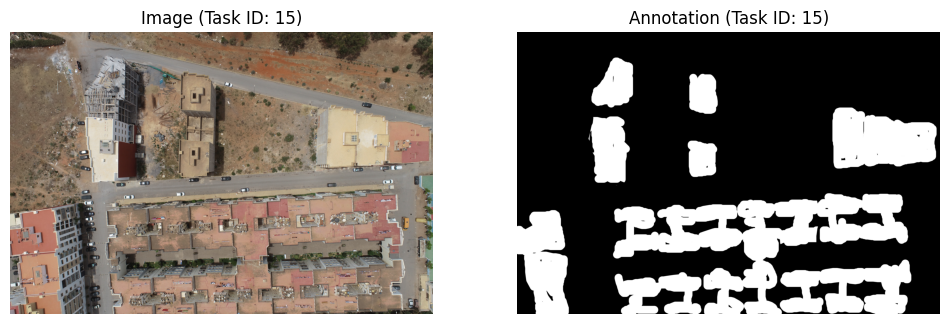

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

task_id_to_visualize = 15
image_folder = "images/images/"
annotation_folder = "annotations/"

try:
    img, annotation = load_image_and_annotation(task_id_to_visualize, image_folder, annotation_folder)

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title(f"Image (Task ID: {task_id_to_visualize})")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title(f"Annotation (Task ID: {task_id_to_visualize})")
    plt.imshow(annotation, cmap='gray')
    plt.axis('off')

    plt.show()
except FileNotFoundError as e:
    print(e)

#Use pretained model and test it in my set of data


In [1]:
!git clone https://github.com/abhirup-ghosh/rooftop-detection-unet-image-segmentation.git


Cloning into 'rooftop-detection-unet-image-segmentation'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 202 (delta 10), reused 34 (delta 8), pack-reused 165 (from 1)
Receiving objects: 100% (202/202), 212.69 MiB | 26.08 MiB/s, done.
Resolving deltas: 100% (52/52), done.
Updating files: 100% (68/68), done.


In [2]:
!pip install tensorflow

In [3]:
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import custom_object_scope

# Define a custom Conv2DTranspose layer that accepts the 'groups' argument
class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid',
                 output_padding=None, data_format=None, dilation_rate=(1, 1),
                 activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', kernel_regularizer=None,
                 bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, **kwargs):
        # Remove 'groups' from kwargs if it exists, as the parent class does not accept it directly in __init__
        kwargs.pop('groups', None)
        super().__init__(filters=filters, kernel_size=kernel_size, strides=strides,
                         padding=padding, output_padding=output_padding,
                         data_format=data_format, dilation_rate=dilation_rate,
                         activation=activation, use_bias=use_bias,
                         kernel_initializer=kernel_initializer, bias_initializer=bias_initializer,
                         kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,
                         activity_regularizer=activity_regularizer, kernel_constraint=kernel_constraint,
                         bias_constraint=bias_constraint, **kwargs)

    # You might need to override get_config if you plan to save this model later
    # def get_config(self):
    #     config = super().get_config()
    #     # Add 'groups' to config if needed, based on how it was used in the original model
    #     return config

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope


with custom_object_scope({'Conv2DTranspose': CustomConv2DTranspose}):
    model = load_model("rooftop-detection-unet-image-segmentation/models/unet_final.h5", compile=False)

print("Model loaded successfully!")

Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


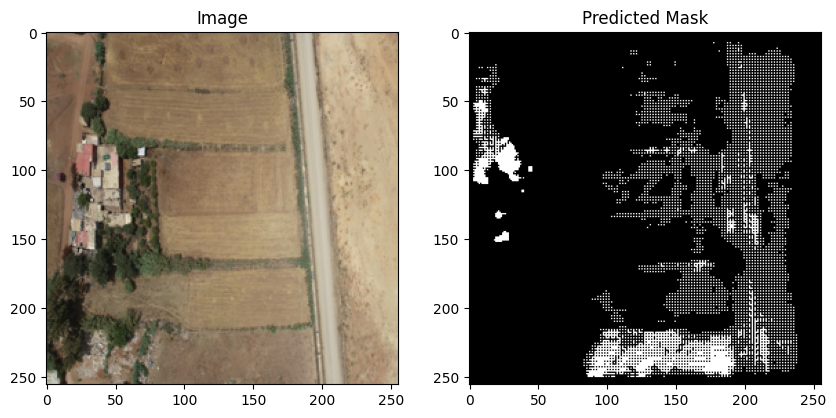

In [6]:

from PIL import Image # Import the Image class
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib for plotting
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import custom_object_scope

image = Image.open("/content/100_0029_0024.JPG").resize((256, 256))
img_array = np.array(image) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred_mask = model.predict(img_array)[0, ..., 0]
binary_mask = (pred_mask > 0.5).astype(np.uint8)

# Display
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(binary_mask, cmap='gray')
plt.title("Predicted Mask")

plt.show()

#Fine tune the pretained model on my annotated data for a better performance

In [7]:
from google.colab import files

uploaded = files.upload()
uploaded_anno = files.upload()

Saving images.zip to images.zip


Saving project-1-at-2025-06-24-13-25-3a442505.zip to project-1-at-2025-06-24-13-25-3a442505.zip


In [8]:
import zipfile
import os

with zipfile.ZipFile("images.zip", 'r') as zip_ref:
    zip_ref.extractall("images")
with zipfile.ZipFile("project-1-at-2025-06-24-13-25-3a442505.zip", 'r') as zip_ref:
    zip_ref.extractall("annotations")

In [9]:
import os
import numpy as np
import cv2

# Paths
mask_dir = "/content/annotations/"
img_dir = "/content/images/images/"

X_finetune = []
Y_finetune = []

for file in os.listdir(mask_dir):
    if file.endswith(".npy") and file.startswith("task-"):
        task_num = file.split("-")[1]  # e.g., task-6-... => '6'
        for ext in ["JPG", "jpg"]:
            img_path = os.path.join(img_dir, f"task{task_num}.{ext}")
            if os.path.exists(img_path):
                break
        else:
            continue


        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0

        # Load mask
        mask = np.load(os.path.join(mask_dir, file))
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)

        X_finetune.append(img)
        Y_finetune.append(mask)

X_finetune = np.array(X_finetune)
Y_finetune = np.array(Y_finetune)

print("Images shape:", X_finetune.shape)
print("Masks shape:", Y_finetune.shape)


Images shape: (143, 256, 256, 3)
Masks shape: (143, 256, 256, 1)


In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_finetune, Y_finetune, batch_size=4, epochs=15)

Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 836ms/step - accuracy: 0.9627 - loss: 0.2019
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 34s 169ms/step - accuracy: 0.9842 - loss: 0.0813
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9862 - loss: 0.0673
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.9863 - loss: 0.0664
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9857 - loss: 0.0709
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9856 - loss: 0.0669
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9855 - loss: 0.0652
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.9867 - loss: 0.0601
Epoch 9/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.9856 - loss: 0.0626
Epoch 10/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.9853 - loss: 0.0634
Epoch 11/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.9850 - loss: 0.0673
Epoch 12/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 1

In [11]:
model.save("fine_tuned_model.h5")


In [57]:
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import custom_object_scope
class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid',
                 output_padding=None, data_format=None, dilation_rate=(1, 1),
                 activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', kernel_regularizer=None,
                 bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(filters=filters, kernel_size=kernel_size, strides=strides,
                         padding=padding, output_padding=output_padding,
                         data_format=data_format, dilation_rate=dilation_rate,
                         activation=activation, use_bias=use_bias,
                         kernel_initializer=kernel_initializer, bias_initializer=bias_initializer,
                         kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,
                         activity_regularizer=activity_regularizer, kernel_constraint=kernel_constraint,
                         bias_constraint=bias_constraint, **kwargs)

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.layers import Conv2DTranspose


with custom_object_scope({'Conv2DTranspose': CustomConv2DTranspose}):
    model = load_model("/content/rooftop-detection-unet-image-segmentation/models/unet_final.h5", compile=False)

# 2. Geler presque toutes les couches
for layer in model.layers[:-10]:
    layer.trainable = False

# 3. Recompiler
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# 4. Fine-tune (léger)
model.fit(X_finetune, Y_finetune, batch_size=4, epochs=10, validation_split=0.1)

# 5. Sauvegarder si ça marche bien
model.save("unet_finetuned_safe.h5")

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 458ms/step - binary_accuracy: 0.9266 - loss: 0.1967 - val_binary_accuracy: 0.9829 - val_loss: 0.0903
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 130ms/step - binary_accuracy: 0.9856 - loss: 0.0790 - val_binary_accuracy: 0.9829 - val_loss: 0.0905
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - binary_accuracy: 0.9844 - loss: 0.0817 - val_binary_accuracy: 0.9829 - val_loss: 0.0880
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - binary_accuracy: 0.9855 - loss: 0.0759 - val_binary_accuracy: 0.9829 - val_loss: 0.0837
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - binary_accuracy: 0.9855 - loss: 0.0745 - val_binary_accuracy: 0.9829 - val_loss: 0.0829
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - binary_accuracy: 0.9854 - loss: 0.0740 - val_binary_accuracy: 0.9829 - val_loss: 0.0858
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - binary_accuracy: 0.9868 - loss: 0.0674 - val_binary_accuracy: 0.9829 - val_loss: 0.0805
Epoc

In [39]:
from google.colab import files

uploaded = files.upload()

Saving 272.png to 272.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


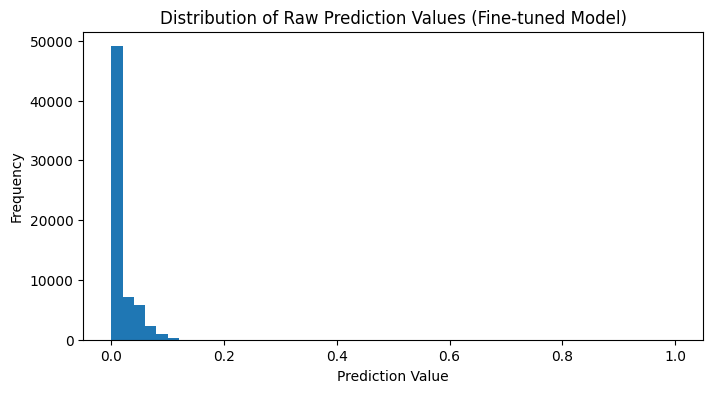

Min raw prediction value: 9.326361549710782e-08
Max raw prediction value: 0.13377982378005981


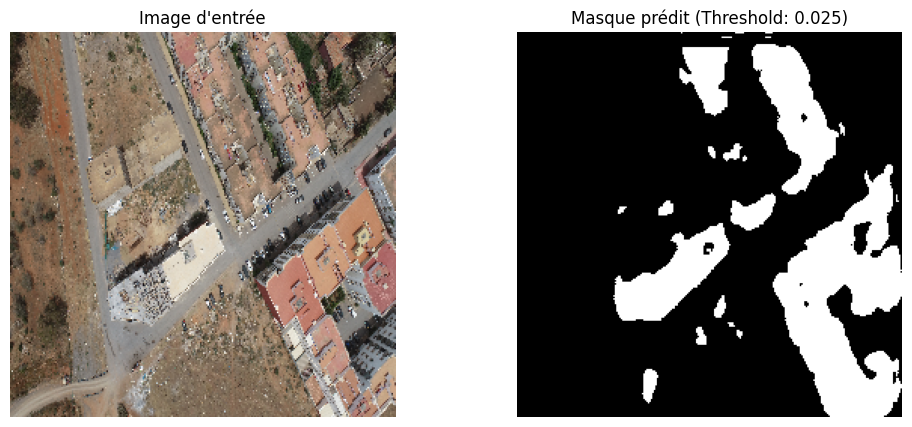

In [88]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import custom_object_scope

# Define the custom Conv2DTranspose layer if needed for loading the model
# (This definition should be in a cell above this one and executed)
class CustomConv2DTranspose(Conv2DTranspose):
    def __init__(self, filters, kernel_size, strides=(1, 1), padding='valid',
                 output_padding=None, data_format=None, dilation_rate=(1, 1),
                 activation=None, use_bias=True, kernel_initializer='glorot_uniform',
                 bias_initializer='zeros', kernel_regularizer=None,
                 bias_regularizer=None, activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, **kwargs):
        kwargs.pop('groups', None)
        super().__init__(filters=filters, kernel_size=kernel_size, strides=strides,
                         padding=padding, output_padding=output_padding,
                         data_format=data_format, dilation_rate=dilation_rate,
                         activation=activation, use_bias=use_bias,
                         kernel_initializer=kernel_initializer, bias_initializer=bias_initializer,
                         kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,
                         activity_regularizer=activity_regularizer, kernel_constraint=kernel_constraint,
                         bias_constraint=bias_constraint, **kwargs)


try:
    with custom_object_scope({'CustomConv2DTranspose': CustomConv2DTranspose}):
         model = load_model("fine_tuned_model.h5", compile=False)
except Exception as e:
    print(f"Error loading model: {e}")
    print("Attempting to load without custom objects in case it was saved differently.")
    model = load_model("fine_tuned_model.h5", compile=False)

image_path = "/content/100_0029_0104.JPG"
img = cv2.imread(image_path)
img = cv2.resize(img, (256, 256))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_input = img / 255.0
img_input = np.expand_dims(img_input, axis=0)


raw_pred_mask = model.predict(img_input)[0, ..., 0]


plt.figure(figsize=(8, 4))
plt.hist(raw_pred_mask.ravel(), bins=50, range=(0, 1))
plt.title("Distribution of Raw Prediction Values (Fine-tuned Model)")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")
plt.show()

print(f"Min raw prediction value: {np.min(raw_pred_mask)}")
print(f"Max raw prediction value: {np.max(raw_pred_mask)}")


threshold = 0.025
pred_bin = (raw_pred_mask > threshold).astype(np.uint8)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Image d'entrée")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_bin, cmap="gray")
plt.title(f"Masque prédit (Threshold: {threshold})")
plt.axis('off')

plt.show()
